In [0]:
# Colab extras
# %%capture
# !7z x group.7z
# !pip install colorama
# !pip install matplotlib==3.1.0 #Downgread matplotlib to use seaborn heatmap (broken for 3.1.1)

# Recurent Neural Network - Who Wrote That?

In [0]:
#System and my modules
import sys

#Data managment
import pandas as pd 
import numpy as np

#SKlearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#PyTorch
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

#For preprocesing
import string
from collections import Counter
from operator import itemgetter

#Visualization 
import seaborn as sns
import matplotlib.pyplot as plt 

### MY TOOLS FOR MINING CONVERSATIONS ###
import MessFileReader as mfr

## Set Parametes and Get Data

In [0]:
#Set conv ID, it is name of folder in which message_1.json file is located
conv_id = '!ExampleGroup'
#Minimum number of words message has to have to be taken into account
min_no_words = 15
#Maximum no words, important to define size of neural net
max_no_words = 50

#Split train/test 
split_frac = 0.8 # 80% train 10% val 10% test

# dataloaders
batch_size = 8

# Instantiate the model
embedding_dim = 400
hidden_dim = 256
n_layers = 1

#Learning rate - learning will be fast
lr=0.00005

# training params
epochs = 30
valid_every = 50 #After how many batches validate?
clip = 5 # gradient clipping, when gradients go out of control

In [967]:
#Create utility objects from conversation 
conv = mfr.readFile(conv_id)
conv_params = mfr.getConvInfo(conv)
messages = mfr.getMessages(conv, ignore_quiters = True)

messages = [mess for mess in messages if 'content' in mess.keys()] #Filter out lack of content
r = range(min_no_words, max_no_words) #Range in which length has to be placed
messages = [mess for mess in messages if len(mess['content'].split()) in r]
print('Messages longer than {} words and shorter than {}: {}\n'.format(min_no_words, max_no_words, len(messages))) 

Messages longer than 15 words and shorter than 50: 3837



## Prepare Data Frame for Classification and Preprocess

In [968]:
df_orgin = []
for mess in messages:
    df_orgin.append((mess['content'], mess['sender_name'],))

df = pd.DataFrame(df_orgin, columns = ['text','name']) 
print('Original counts:')
cts = df['name'].value_counts()
min_messages = cts.min()
participants = cts.index.tolist()
output_size = len(participants)
print(cts)

#Get indices of messages of each participant
indices = []
for part in participants:
    all_inds = df.index[df['name'] == part]
    #Take amount of smallest number of messages and append indices
    indices.extend(np.random.choice(all_inds, min_messages, replace=False).tolist())

#Balance Data 
data = df.loc[indices] #Get only 
print('\nBalanced counts:')
print(data['name'].value_counts())

#Define features and labels 
messages_raw = data['text'].tolist()
labels_raw = data['name'].tolist()

Original counts:
Bartłomiej Cerek    1455
Example Person3     1298
Example Person1      501
Example Person2      340
Example Person4      243
Name: name, dtype: int64

Balanced counts:
Bartłomiej Cerek    243
Example Person4     243
Example Person2     243
Example Person1     243
Example Person3     243
Name: name, dtype: int64


### Preprocess
- Categorical to numeric
- All to lowercase 
- Delete interpunction
- Split to words 
- Delte suspicious +15 characters long words (links, hahahas, etc) 

Also create list of all words to then count them and create vocabulary.

In [0]:
#One-liner to make quickly numerical vector, then One Hot Encode
category_labels = pd.Series(labels_raw).astype('category')
classes = category_labels.dtype.categories.to_list()

labels = category_labels.cat.codes.to_numpy(dtype='int32')
labels_onehot = np.zeros((len(labels), output_size))
labels_onehot[np.arange(len(labels)), labels] = 1

#Preprocess features
messages_tokenized = []
words = []
for mess in messages_raw:
    mess = mess.lower() #To lower
    mess = ''.join([c for c in mess if c not in string.punctuation]) #Delete punctuaion 
    mess = mess.split() #split for tokens
    mess = [w for w in mess if len(w) < 15] #filterout strangely long words
    messages_tokenized.append(mess) #Add to messages tokenized
    words.extend(mess) #List of all words in messages

### Transform features 
Change features to numerical vectors of same length, to be able to pass them through the network.

In [0]:
#Build a dictionary that maps words to integers
vocab_to_int = {}
words_rank = Counter(words).most_common()
for i, (word, _) in enumerate(words_rank):
    vocab_to_int[word] = i+1

# use the dict to tokenize each review in reviews_split
features_ints = []
for mess in messages_tokenized:
    tokens = [vocab_to_int[word] for word in mess]
    features_ints.append(tokens)

In [971]:
#No words
print('Unique words: ', len(vocab_to_int))
#Most popular words
print('Ten most popular words:')
words_rank[:10]

Unique words:  7148
Ten most popular words:


[('i', 757),
 ('to', 667),
 ('w', 632),
 ('nie', 597),
 ('na', 542),
 ('z', 418),
 ('jak', 319),
 ('że', 299),
 ('xd', 280),
 ('się', 279)]

In [0]:
#Function for padding
def pad_features(features_ints, seq_length):
    ''' Return features of features_ints, where each message is padded with 0's.
    '''
    features=[]
    for rev in features_ints:
        if len(rev) < seq_length:
            diff = seq_length - len(rev)
            zeros = [0 for i in range(diff)]
            features.append(zeros+rev)
        else:
            features.append(rev)
    features = np.array(features)
    return features

In [973]:
#Pad features to be same length and transform to numpy 
features = pad_features(features_ints, seq_length=max_no_words)

print('Features: \n', features[:3])
print('Labels: \n', labels[:3])

Features: 
 [[   0    0    0    0    0    0    0  240    8    4   27   88    3 1035
     3 1870   16 1871   18  703    7    2    4 1872   10 1873   51   19
    40 1874   23   31   44  191   38  456   13   53   23  704  241  547
    43   99   23 1875   14   49  705 1876]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 1036   11   27 1877    1 1878   26   16 1879  548    7
    63  354  549   50   80    4   37  163]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 1880    9    4   91 1881 1882    6
  1883 1037   17 1884  706   16   26 1885]]
Labels: 
 [0 0 0]


## Split Data and create Loaders

In [974]:
## split data into training, validation, and test data
X_train, X_test_val, y_train, y_test_val = train_test_split(features, labels_onehot, test_size=1-split_frac, stratify=labels_onehot)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, stratify=y_test_val)

## print out the shapes of resultant feature data
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(972, 50)
(122, 50)
(121, 50)


In [0]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

#Create loader, shuffle data, drop last incomplete batch 
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last = True)

In [976]:
# test
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([8, 50])
Sample input: 
 tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  105, 1411,
          219,   61,   24,  281,  808,    1, 1411, 1412, 3447,   58,    5,    2,
          666,    9],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   29,   43,
           69,  572,  743, 2637,    6, 1226,    6,  335,    1,    6,  420,  355,
           17,   92,   11,    3,  806,    6,  251,  807,  370, 2638,   15,   83,
           22, 2639],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,   20,    1,   19,
           49, 4445,   16, 4446,  467, 4447,  285, 4448,   25, 4449, 4450,    5,
         

## Define Neural Network Architecture

In [0]:
class RNN(nn.Module):
    """
    The RNN model that will be used to perform analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        #Model variables
        super(RNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #Layers
        self.embed = nn.Embedding(vocab_size, embedding_dim) #Words embedding
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True) #Long short term memory
        self.fc1 = nn.Linear(hidden_dim, 100) #Fully connected
        self.fc2 = nn.Linear(100, output_size) #Fully connected
        self.dropout = nn.Dropout(0.4) # Dropout of fully connected

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.shape[0]

        x_embed = self.embed(x)
        lstm_out, hidden = self.lstm(x_embed, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        lstm_out = self.dropout(lstm_out)

        fc1_out = self.dropout(torch.sigmoid(self.fc1(lstm_out)))

        sig_out = torch.sigmoid(self.fc2(fc1_out))
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1, self.output_size)
        sig_out = sig_out[:, -1] # get last batch of labels

        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """
        Initializes hidden state 
        """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        # No clue WTF
        weight = next(self.parameters()).data
        if (device == 'cuda'):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden
        

## Create Network Instance

In [978]:
# Check if GPU aviable
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [979]:
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding 

net = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
net.to(device)

print(net)

RNN(
  (embed): Embedding(7149, 400)
  (lstm): LSTM(400, 256, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
#Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

## Train the Network
Define validation function that will be called after set number of batches.\
We validate few times in epoch since learning will be quite fast and using small batches is most effective. \
Then train network as usual.

In [0]:
# Validation function - NOT PURE! uses also batch_size, valid_loader

def validate_network(net, min_val_loss, epoch, counter):
    # Get validation loss
    val_h = net.init_hidden(batch_size)
    val_losses = []
    net.eval() #Set model to evealuation
    for inputs, labels in valid_loader:
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data for each in val_h])

        #Use GPU if present
        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = net.forward(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        val_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_losses)
    
    print("Epoch: {}/{}...".format(e+1, epochs),
          "Batches done: {}...".format(counter),
          "Val Loss: {:.6f}".format(avg_val_loss))
    
    if avg_val_loss <= min_val_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        min_val_loss,
        avg_val_loss))
        torch.save(net.state_dict(), 'model.pt')
        min_val_loss = avg_val_loss

    net.train() #Comeback to training

    return min_val_loss

In [982]:
### TRAINING ###
counter = 0
min_val_loss = np.Inf
net.train()

# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        #Use GPU if present
        inputs, labels = inputs.to(device), labels.to(device)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net.forward(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output, labels.float())
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # VALIDATION
        if counter % valid_every == 0:
            #Validate network and return minimal validation loss. 
            #If obtained model was better it will be saved.
            min_val_loss = validate_network(net, min_val_loss, e, counter)

Epoch: 1/30... Batches done: 50... Val Loss: 0.635188
Validation loss decreased (inf --> 0.635188).  Saving model ...
Epoch: 1/30... Batches done: 100... Val Loss: 0.611139
Validation loss decreased (0.635188 --> 0.611139).  Saving model ...
Epoch: 2/30... Batches done: 150... Val Loss: 0.591227
Validation loss decreased (0.611139 --> 0.591227).  Saving model ...
Epoch: 2/30... Batches done: 200... Val Loss: 0.574019
Validation loss decreased (0.591227 --> 0.574019).  Saving model ...
Epoch: 3/30... Batches done: 250... Val Loss: 0.558425
Validation loss decreased (0.574019 --> 0.558425).  Saving model ...
Epoch: 3/30... Batches done: 300... Val Loss: 0.546705
Validation loss decreased (0.558425 --> 0.546705).  Saving model ...
Epoch: 3/30... Batches done: 350... Val Loss: 0.535090
Validation loss decreased (0.546705 --> 0.535090).  Saving model ...
Epoch: 4/30... Batches done: 400... Val Loss: 0.522083
Validation loss decreased (0.535090 --> 0.522083).  Saving model ...
Epoch: 4/30...

## Test the Network

In [983]:
#Load best model 
net.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [0]:
# Get test data loss and accuracy
losses = []
pred = []
corr = []

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
for inputs, labels in test_loader:
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    #Use GPU if present
    inputs, labels = inputs.to(device), labels.to(device)
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels.float())
    losses.append(test_loss.item())
    
    # convert output probabilities to predicted class and encode labels for comp
    corr = corr + torch.argmax(labels,dim=1).tolist()
    pred = pred + torch.argmax(output,dim=1).tolist()  

Test loss: 0.457
Test accuracy: 39.167


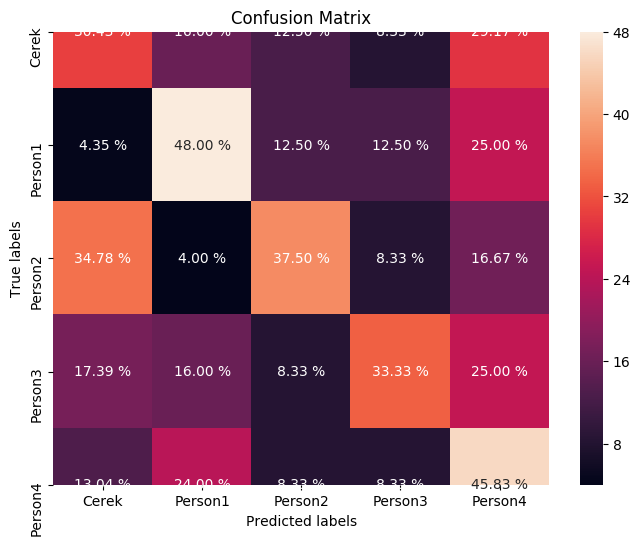

In [985]:
#Evaluate Test
pred_class = [classes[i] for i in pred]
corr_class = [classes[i] for i in corr]

avg_loss = np.mean(losses)
acc = accuracy_score(pred_class, corr_class)

print("Test loss: {:.3f}".format(avg_loss))
print("Test accuracy: {:.3f}".format(acc*100))

cm = confusion_matrix(corr_class, pred_class, labels = classes)
f = np.sum(cm, axis =1) # scaling factor
cm = cm / f *100

#Visualization
fig, ax = plt.subplots(figsize=(8,6), dpi = 100)
annot_kws = {"ha": 'left',"va": 'top'}
ax = sns.heatmap(cm, annot=True, ax = ax, fmt='.2f'); #annot=True to annotate cells

# labels, title and ticks
sur_names = [part.split()[1] for part in classes]
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(sur_names)
ax.yaxis.set_ticklabels(sur_names);

for t in ax.texts: t.set_text(t.get_text()  + " %")